# P08: Fisher matrices and information

## Problem 1: Fisher matrix for a Gaussian likelihood

Assume data $\boldsymbol{x}$ with mean $\boldsymbol{\mu}$ and covariance $\boldsymbol{\mathrm{C}}$, following an $d$-dimensional Gaussian distribution in data space. Recall that $\langle\boldsymbol{x}\rangle =\boldsymbol{\mu}$ and $\langle\boldsymbol{\mathrm{D}}\rangle \coloneqq \langle(\boldsymbol{x} - \boldsymbol{\mu})\otimes (\boldsymbol{x} - \boldsymbol{\mu})\rangle = \boldsymbol{\mathrm{C}}$. 

1. Show that in this case, the Fisher matrix can be written as:
$$
\boldsymbol{\mathrm{F}}_{\alpha\beta} = \frac{1}{2}\mathrm{tr}\left(\boldsymbol{\mathrm{C}}^{-1} \frac{\partial\boldsymbol{\mathrm{C}}}{\partial\boldsymbol{\theta}^\alpha}\boldsymbol{\mathrm{C}}^{-1} \frac{\partial\boldsymbol{\mathrm{C}}}{\partial\boldsymbol{\theta}^\beta} + 2\boldsymbol{\mathrm{C}}^{-1} \frac{\partial \boldsymbol{\mu}}{\partial\boldsymbol{\theta}^\alpha} \frac{\partial \boldsymbol{\mu}^\mathrm{T}}{\partial\boldsymbol{\theta}^\beta} \right)\,. 
$$

2. Show that any linear transformation of the data will leave the Fisher matrix unchanged. Hint: any vector, $\boldsymbol{x}$, changes as $\boldsymbol{y} = \boldsymbol{\mathrm{A}}\boldsymbol{x}$ under a linear transformation, where $\boldsymbol{\mathrm{A}}$ is the transformation matrix.

## Problem 2: Fisher matrix of supernovae and pitfalls

The code snippet below provides you with the luminosity distance used in cosmology. This measurement (ignoring some additional complication) is used in cosmology by observing supernovae of type Ia to deduce the expansion history of the Universe and therefore its content.
The code calculates the luminosity distance for $N_\mathrm{sn}$ and parameters $\theta$. The variable $N_\mathrm{trapz}$ controls the number of function evaluations in the numerical integration of the luminosity distance, the latter is given by:

$$
d_\mathrm{L}(a) = \frac{1}{a|K|^{1/2}}f_{K}\left(-|K|^{1/2}\chi_\mathrm{H}\int_1^{a}\frac{\mathrm{d}a'}{a'^2E(a')}\right)\,,
$$

where $\chi_\mathrm{H} = c/H_0$ is the Hubble radius $c$ the speed of light and $H_0$ the expansion rate of the Universe today. $K$ measures the spatial curvature and is given by $K= \Omega_\mathrm{k}/\chi_H^2$. The function $f_{K}$ is

$$

f_K(x) = \left\{\begin{array}{cc}
\sin(x) & \mathrm{if\;} K > 0\,,\\
x & \mathrm{if\;} K = 0\,,\\
\mathrm{sinh}(x) & \mathrm{if\;} K < 0\;.
\end{array}\right.
$$

Lastly, $E(a)$ is the dimensionless Hubble function, also called expansion function. It is given by:

$$
E(a) = a^{-3/2}\left(\Omega_\mathrm{m} + \Omega_\Lambda a^{-3(w_0 + w_\mathrm{a})}\exp\left(3w_\mathrm{a}(a-1)\right) + \Omega_\mathrm{K}a\right)^{1/2}\,.
$$

The integral is carried out with a trapezoidal rule using $N_\mathrm{trapz}$ points.

The model consists of five parameters, which we bundle into the vector $\boldsymbol{\theta}$ such that:

$$
\boldsymbol{\theta}^\mathrm{T} = (\Omega_\mathrm{m}, \Omega_\mathrm{k},\chi_\mathrm{H}, w_0, w\mathrm{a})\,,\quad \boldsymbol{\theta}^\mathrm{T}_0 =   (0.3, 0., 4.0, -1,.0)\, 
$$

the meaning of this parameters is the fractional matter density in the Universe, the curvature density parameter, the Hubble radius (or the Hubble constant, as the speed of light is constant) and two parameters for dynamical dark energy.

Lastly note that I added a tiny random noise on the final value of the luminosity distance to mimic numerical noise.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

theta_0 = [0.3, 0., 4.0, -1,.0]



# luminosity distance as a function parameters
def luminosity_distance(theta, N_trapz, N_sn):


    np.random.seed(seed=42)
    # randomly chose redshifts between 0 and 1.5 for the SN
    z_sn = np.random.rand(N_sn)*1.5
    a_sn = 1/(1+z_sn)
    a_int = []

    np.random.seed()

    # integration variable
    for i_a, val_a in enumerate(a_sn):
        a_int.append(np.linspace(1,val_a, N_trapz))
    a_int = np.array(a_int)

    # expansion function as a function of parameters and scale factor
    Om = theta[0]
    Ok = theta[1]
    Ol = 1.0 - Ok - Om
    chih = theta[2]
    w0 = theta[3]
    wa = theta[4]
    eofa = a_int**-1.5*(Om + Ol*a_int**(-3*(w0 + wa))*np.exp(3*wa*(a_int-1)) + Ok*a_int)**.5
    chih = theta[2]
    Ok = theta[1]
    chi = -chih*np.trapezoid(1/(a_int**2*eofa), x = a_int)
    chi += chi*np.random.rand(N_sn)*1e-6
    K = np.abs(Ok/chih**2)
    if Ok > 0:
        return 1/a_sn*K**(-.5)*np.sin(K**.5*chi)
    if Ok < 0:
        return 1/a_sn*K**(-.5)*np.sinh(K**.5*chi)
    if Ok == 0:
        return 1/a_sn*chi




1. Write a function to numerically calculate the derivatives of the luminosity distance with respect to all parameters. You can do this, using finite differencing: $$
\frac{\partial f(x)}{\partial x} = \frac{f(x + h) - f(x-h)}{2h}\,,$$ for some small $h$.

In [4]:
def numerical_derivatives(theta, N_trapz, N_sn, h=1e-5):
    n_params = len(theta)
    derivatives = np.zeros((N_sn, n_params))
    
    for i in range(n_params):
        theta_plus = theta.copy()
        theta_minus = theta.copy()
        theta_plus[i] += h
        theta_minus[i] -= h
        
        d_plus = luminosity_distance(theta_plus, N_trapz, N_sn)
        d_minus = luminosity_distance(theta_minus, N_trapz, N_sn)
        
        derivatives[:, i] = (d_plus - d_minus)/(2*h)
    
    return derivatives


2. Assume that the data points are not correlated and have all a relative error of 10 per cent. Write a code to calculate the Fisher matrix by using the equation from problem 1 and ignore any parameter dependence in the covariance matrix. Matrix inversion can be done by `numpy.linalg.inv(matrix)`.

In [5]:
def calculate_fisher_matrix(theta, N_trapz, N_sn, h=1e-5):
    # Get derivatives
    derivatives = numerical_derivatives(theta, N_trapz, N_sn, h)
    
    # Calculate luminosity distances for nominal parameters
    d_L = luminosity_distance(theta, N_trapz, N_sn)
    
    # Create diagonal covariance matrix with 10% relative errors
    sigma = 0.1 * d_L  # 10% relative error
    C = np.diag(sigma**2)
    C_inv = np.linalg.inv(C)
    
    # Calculate Fisher matrix
    fisher = np.dot(derivatives.T, np.dot(C_inv, derivatives))
    
    return fisher

3. Plot the conditional and marginal uncertainties $1\sigma$ of all parameters as a function of the step width, $h$, used for the finite differencing. 


In [6]:
def plot_uncertainties_vs_h(theta, N_trapz, N_sn):
    h_values = np.logspace(-6, -1, 20)
    uncertainties = np.zeros((len(h_values), len(theta)))
    
    for i, h in enumerate(h_values):
        fisher = calculate_fisher_matrix(theta, N_trapz, N_sn, h)
        cov = np.linalg.inv(fisher)
        uncertainties[i] = np.sqrt(np.diag(cov))
    
    plt.figure(figsize=(10, 6))
    for i in range(len(theta)):
        plt.semilogx(h_values, uncertainties[:, i], label=f'Parameter {i+1}')
    
    plt.xlabel('Step width h (log scale)')
    plt.ylabel('Uncertainty (1σ) (log scale)')
    plt.yscale('log')
    plt.grid(True)
    plt.legend()
    plt.title('Conditional and Marginal Uncertainties as a Function of Step Width h')
    plt.show()


4. Show the 2d marginal $1\sigma$ uncertainty for the parameters $w_0$ and $w_\mathrm{a}$. 

In [8]:
def plot_2d_uncertainty(theta, N_trapz, N_sn, h=1e-5):
    fisher = calculate_fisher_matrix(theta, N_trapz, N_sn, h)
    cov = np.linalg.inv(fisher)
    
    # Extract w0, wa covariance (parameters 4 and 5)
    w0_wa_cov = cov[3:5, 3:5]
    
    # Create grid for contour plot
    x = np.linspace(-5, 3, 100)
    y = np.linspace(-100, 100, 100)
    X, Y = np.meshgrid(x, y)
    pos = np.dstack((X, Y))
    
    # Create multivariate normal distribution
    rv = multivariate_normal([theta[3], theta[4]], w0_wa_cov)
    Z = rv.pdf(pos)
    
    plt.figure(figsize=(10, 8))
    plt.contourf(X, Y, Z, levels=20, cmap='viridis')
    plt.colorbar(label='Probability Density')
    plt.xlabel('w₀')
    plt.ylabel('wa')
    plt.title('2D Marginal Uncertainty for Parameters w₀ and wa')
    plt.show()

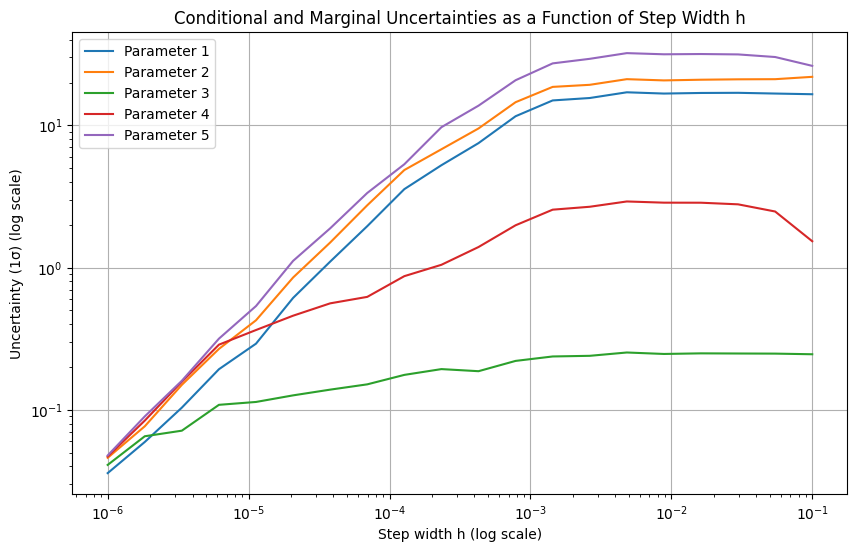

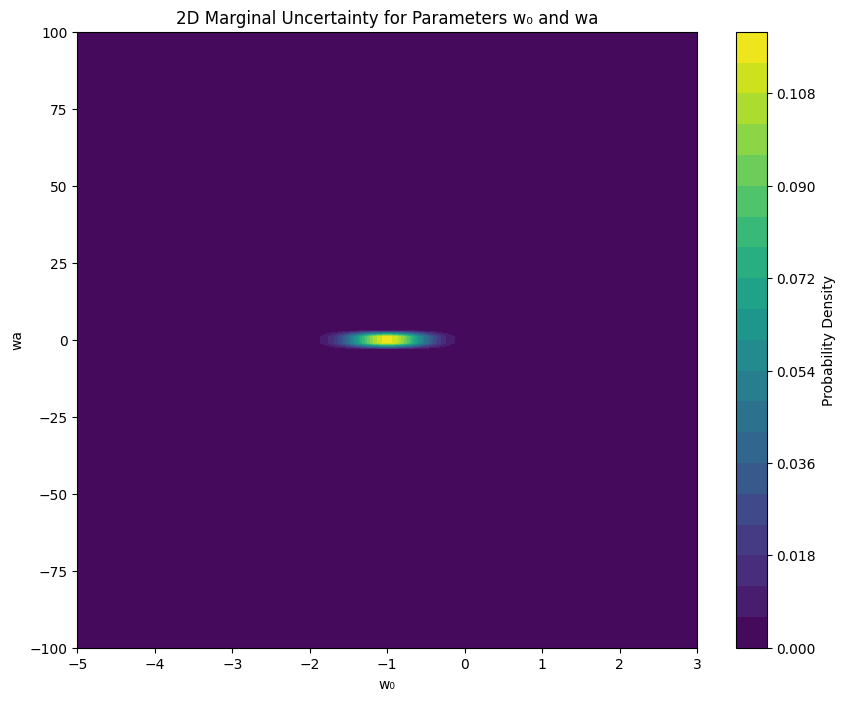

In [9]:
# Set parameters
N_trapz = 100
N_sn = 100
theta = theta_0  # Using the provided fiducial values

# Run all analyses
plot_uncertainties_vs_h(theta, N_trapz, N_sn)
plot_2d_uncertainty(theta, N_trapz, N_sn)